In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from collections import Counter
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Read HMP data and metadata

In [2]:
# taxonomy
df_tax = pd.read_csv('HMP/HMP_taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
new_taxon = []
taxon_label = ['k','p','c','o','f','g','s']
for t1 in df_tax['Taxon']:
    curr_taxon = []
    for i, t2 in enumerate(t1.split(';')):
        curr_taxon.append(taxon_label[i]+'__'+t2)
    new_taxon.append((';').join(curr_taxon))
df_tax['Taxon'] = new_taxon
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax['Genus'] = [t.split('g__')[1].split('_')[0].split('-')[0].split(';')[0] if 'g__' in t else 'unclassified' for t in df_tax.Taxon]

# metadata
df_meta = pd.read_csv("HMP/HMP_metadata.txt", sep="\t", index_col=0)
df_meta['host_visit_id'] = [str(x)+'_'+str(y) for x,y in zip(df_meta.host_subject_id, df_meta.visit_no)]
df_meta = df_meta[df_meta.env.isin(['gastrointestinal_tract','oral_cavity'])]

# count
df_count = pd.read_csv('HMP/HMP_feature_table.txt', sep="\t", index_col=0)
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)

# Fig. 3b

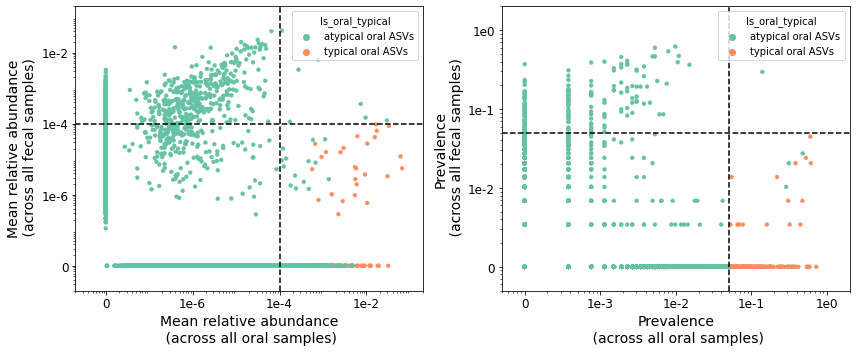

In [3]:
df_oral_mean_relabun = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='oral_cavity'].index))].mean().to_frame().rename({0:'MeanRelabun_Oral'}, axis=1)
df_oral_prevalence = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='oral_cavity'].index))]
df_oral_prevalence = (df_oral_prevalence>1e-3).astype(int).mean().to_frame().rename({0:'Prevalence_Oral'}, axis=1)
df_oral = pd.merge(df_oral_mean_relabun, df_oral_prevalence, left_index=True, right_index=True, how='inner')

df_gut_mean_relabun = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='gastrointestinal_tract'].index))].mean().to_frame().rename({0:'MeanRelabun_Gut'}, axis=1)
df_gut_prevalence = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.env=='gastrointestinal_tract'].index))]
df_gut_prevalence = (df_gut_prevalence>1e-3).astype(int).mean().to_frame().rename({0:'Prevalence_Gut'}, axis=1)
df_gut = pd.merge(df_gut_mean_relabun, df_gut_prevalence, left_index=True, right_index=True, how='inner')

df = pd.merge(df_oral, df_gut, left_index=True, right_index=True, how='left').fillna(0)
num_oral_asvs = len(df)
relabun_cutoff = 1e-4
prevalence_cutoff = 0.05
df['Is_oral_typical'] = 'atypical oral ASVs'
df.loc[(df.MeanRelabun_Oral > relabun_cutoff) & (df.Prevalence_Oral > prevalence_cutoff) & (df.MeanRelabun_Gut <= relabun_cutoff) & (df.Prevalence_Gut <= prevalence_cutoff), 'Is_oral_typical'] = 'typical oral ASVs'
filtered_oral_asvs = list(df[df.Is_oral_typical=='typical oral ASVs'].index)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

df2plot = deepcopy(df)
df2plot.loc[df2plot.MeanRelabun_Gut==0.0, 'MeanRelabun_Gut'] = 1e-8
df2plot.loc[df2plot.MeanRelabun_Oral==0.0, 'MeanRelabun_Oral'] = 1e-8
df2plot.loc[df2plot.Prevalence_Gut==0.0, 'Prevalence_Gut'] = 1e-3
df2plot.loc[df2plot.Prevalence_Oral==0.0, 'Prevalence_Oral'] = 1e-4

# mean relative abundance
_ = sns.scatterplot(x='MeanRelabun_Oral', y='MeanRelabun_Gut', data=df2plot, ax=ax[0], hue='Is_oral_typical', palette='Set2', edgecolor=None, s=16)
_ = ax[0].set_xscale('log')
_ = ax[0].set_yscale('log')
_ = ax[0].set_xlim([2e-9,2e-1])
_ = ax[0].set_ylim([2e-9,2e-1])
_ = ax[0].set_xticks([1e-8,1e-6,1e-4,1e-2])
_ = ax[0].set_xticklabels(['0','1e-6','1e-4','1e-2'], fontsize=12)
_ = ax[0].set_yticks([1e-8,1e-6,1e-4,1e-2])
_ = ax[0].set_yticklabels(['0','1e-6','1e-4','1e-2'], fontsize=12)
_ = ax[0].plot([2e-9,2e-1],[relabun_cutoff, relabun_cutoff], 'k--')
_ = ax[0].plot([relabun_cutoff, relabun_cutoff], [2e-9,8e-1], 'k--')
_ = ax[0].set_xlabel('Mean relative abundance\n (across all oral samples)', fontsize=14)
_ = ax[0].set_ylabel('Mean relative abundance\n (across all fecal samples)', fontsize=14)

# prevalence
_ = sns.scatterplot(x='Prevalence_Oral', y='Prevalence_Gut', data=df2plot, ax=ax[1], hue='Is_oral_typical', palette='Set2', edgecolor=None, s=16)
_ = ax[1].set_xscale('log')
_ = ax[1].set_yscale('log')
_ = ax[1].set_xlim([5e-5,2])
_ = ax[1].set_ylim([5e-4,2])
_ = ax[1].set_xticks([1e-4,1e-3,1e-2,1e-1,1e0])
_ = ax[1].set_xticklabels(['0','1e-3','1e-2','1e-1','1e0'], fontsize=12)
_ = ax[1].set_yticks([1e-3,1e-2,1e-1,1e0])
_ = ax[1].set_yticklabels(['0','1e-2','1e-1','1e0'], fontsize=12)
_ = ax[1].plot([5e-5,2],[prevalence_cutoff, prevalence_cutoff], 'k--')
_ = ax[1].plot([prevalence_cutoff, prevalence_cutoff], [5e-4,2], 'k--')
_ = ax[1].set_xlabel('Prevalence\n (across all oral samples)', fontsize=14)
_ = ax[1].set_ylabel('Prevalence\n (across all fecal samples)', fontsize=14)

plt.tight_layout()

# Fig. 3c

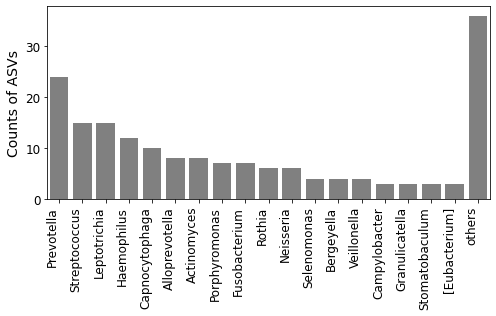

In [4]:
df_tax_oral = df_tax.loc[df_tax.ASV.isin(filtered_oral_asvs), ['Genus']]

fig, ax = plt.subplots(figsize=(7,4.5))
df_stat = pd.DataFrame.from_dict(dict(Counter(df_tax_oral.Genus)), orient="index").sort_values(0, ascending=False).reset_index().rename({'index':'Genus', 0:'Count'}, axis=1)
df_stat2 = df_stat[df_stat.Count>2]
df_stat2 = pd.concat([df_stat2, pd.DataFrame([['others', df_stat[df_stat.Count<=2].Count.sum()]], columns=['Genus','Count'])])
_ = sns.barplot(x="Genus", y="Count", data=df_stat2, ax=ax, color='gray')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize=12)
_ = ax.set_ylabel('Counts of ASVs', fontsize=14)
_ = ax.set_yticks([0,10,20,30])
_ = ax.set_yticklabels(['0','10','20','30'], fontsize=12)
_ = ax.set_xlabel('')
plt.tight_layout()

# Fig. 3d

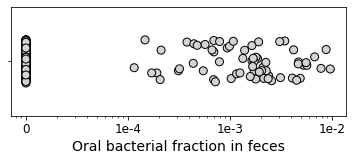

In [5]:
df_oral_fraction = df_relabun.loc[set(df_relabun.index).intersection(set(df_meta[df_meta.body_site=='stool'].index)), filtered_oral_asvs].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
df_oral_fraction.loc[df_oral_fraction.OralFrac == 0, 'OralFrac'] = 1e-5
_ = sns.stripplot(x="OralFrac", data=df_oral_fraction, ax=ax, s=8, edgecolor='k', linewidth=1, color='lightgray', jitter=0.2, orient='h')
_ = ax.set_xscale('log')
_ = ax.set_xticks([1e-5,1e-4,1e-3,1e-2])
_ = ax.set_xticklabels(['0','1e-4','1e-3','1e-2'], fontsize=12)
_ = ax.set_xlabel('Oral bacterial fraction in feces', fontsize=14)